# Método de Newton–Raphson em Física Computacional

Neste notebook, vamos:

1. Apresentar o método de Newton–Raphson em 1D e 2D.
2. Entender a base matemática (derivação via série de Taylor).
3. Discutir critérios de convergência e implementações em Python, com comentários de cada etapa.
4. Exemplificar com:
   - Polinômio em 1D.
   - Equação de Kepler em 1D.
   - Comparação de convergência (polinômio vs Kepler).
   - Sistema não linear em 2D (exemplo físico).

---

## 1. Fundamento Matemático do Método em 1D

Partimos da expansão de Taylor de $f(x)$ em torno de $x_n$:

$$
0 = f(x^*) \approx f(x_n) + f'(x_n) \,(x^* - x_n) + \dots
$$

Negligenciando termos de ordem superior, isolamos $x^*$:

$$
x^* \approx x_n - \frac{f(x_n)}{f'(x_n)} = x_{n+1}
$$

Essa iteração converge **quadraticamente** se $f'(x^*) \neq 0$.

Critérios de parada comuns:
- $|f(x_n)| < \mathrm{tol}$
- $|x_{n+1} - x_n| < \mathrm{tol}$
- $n \geq \mathrm{max\_iter}$

In [1]:
import numpy as np

# Método de Newton–Raphson 1D, retornando histórico de iterações
def newton_raphson(f, df, x0, tol=1e-8, max_iter=100):
    """
    Encontra raiz de f(x)=0 com Newton–Raphson em 1D.

    Parâmetros:
    - f: função alvo f(x)
    - df: derivada f'(x)
    - x0: chute inicial
    - tol: tolerância de convergência
    - max_iter: máximo de iterações

    Retorna:
    - x_new: estimativa da raiz
    - hist: histórico de (x_n, f(x_n))
    """
    x = x0
    hist = [(x, f(x))]
    for _ in range(max_iter):
        fx = f(x)
        dfx = df(x)
        if abs(dfx) < 1e-14:
            raise ZeroDivisionError("Derivada muito pequena.")
        x_new = x - fx / dfx
        hist.append((x_new, f(x_new)))
        if abs(x_new - x) < tol and abs(f(x_new)) < tol:
            return x_new, hist
        x = x_new
    raise RuntimeError("Não convergiu.")

# Exemplo de teste: raiz de x**2 - 2 = 0 (sqrt(2))
def f_test(x):
    """Função teste f(x) = x^2 - 2"""
    return x**2 - 2
def df_test(x):
    """Derivada teste f'(x) = 2x"""
    return 2*x
try:
    root_test, hist_test = newton_raphson(f_test, df_test, x0=1.0)
    print("Teste 1D (sqrt(2)):", root_test)
except Exception as e:
    print("Falha no teste 1D:", e)

Teste 1D (sqrt(2)): 1.4142135623730951


## 2. Exemplos em 1D

### 2.1 Polinômio: $x^3 - 2x - 5 = 0$

In [2]:
# Definições para o polinômio
f_poly = lambda x: x**3 - 2*x - 5
df_poly = lambda x: 3*x**2 - 2
# Execução do método
root_poly, hist_poly = newton_raphson(f_poly, df_poly, x0=2.0)
print("Raiz aproximada do polinômio:", root_poly)

Raiz aproximada do polinômio: 2.0945514815423265


### 2.2 Equação de Kepler: $E - e\sin E = M$

In [3]:
# Parâmetros para Kepler
e = 0.7
M = 1.0
# Funções de Newton
f_kepler = lambda E: E - e*np.sin(E) - M
df_kepler = lambda E: 1 - e*np.cos(E)
# Execução do método
root_kepler, hist_kepler = newton_raphson(f_kepler, df_kepler, x0=M)
print("Solução da equação de Kepler:", root_kepler)

Solução da equação de Kepler: 1.694638912091841


### 2.3 Comparação de Convergência (Polinômio vs Kepler)

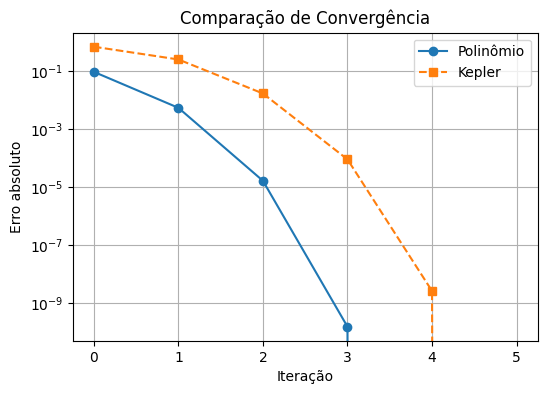

In [4]:
# Cálculo de erros ao longo das iterações
errors_poly = [abs(x - root_poly) for x, _ in hist_poly]
errors_kepler = [abs(E - root_kepler) for E, _ in hist_kepler]

# Tentar plotar se matplotlib estiver disponível, senão exibir vetores
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,4))
    plt.plot(range(len(errors_poly)), errors_poly, 'o-', label='Polinômio')
    plt.plot(range(len(errors_kepler)), errors_kepler, 's--', label='Kepler')
    plt.yscale('log')
    plt.xlabel('Iteração')
    plt.ylabel('Erro absoluto')
    plt.title('Comparação de Convergência')
    plt.legend()
    plt.grid(True, which='both')
    plt.show()
except ImportError:
    print("Matplotlib não disponível. Erros:")
    print("Polinômio:", errors_poly)
    print("Kepler:", errors_kepler)

## 3. Método de Newton–Raphson em 2D

Sistema:

$$
\begin{cases}
  f_1(x, y) = 0, \\
  f_2(x, y) = 0
\end{cases}
$$

Iteração:

$$
\vec{X}_{n+1} = \vec{X}_n - J^{-1}(x_n,y_n)\,\vec{F}(x_n,y_n)
$$

In [5]:
# Funções 2D (interseção circulo/exponencial)
def f1_2d(x, y): return x**2 + y**2 - 4
def f2_2d(x, y): return np.exp(x) + y - 1

def jacobian(x, y):
    return np.array([[2*x, 2*y], [np.exp(x), 1]])

def newton_raphson_2d(f1, f2, jacobian, x0, y0, tol=1e-8, max_iter=50):
    x, y = x0, y0
    hist = [(x, y)]
    for _ in range(max_iter):
        J = jacobian(x, y)
        F = np.array([f1(x, y), f2(x, y)])
        delta = np.linalg.solve(J, F)
        x_new, y_new = x - delta[0], y - delta[1]
        hist.append((x_new, y_new))
        if np.linalg.norm([x_new - x, y_new - y]) < tol:
            return (x_new, y_new), hist
        x, y = x_new, y_new
    raise RuntimeError("Não convergiu em 2D.")

Solução 2D: x = -1.816264, y = 0.837368


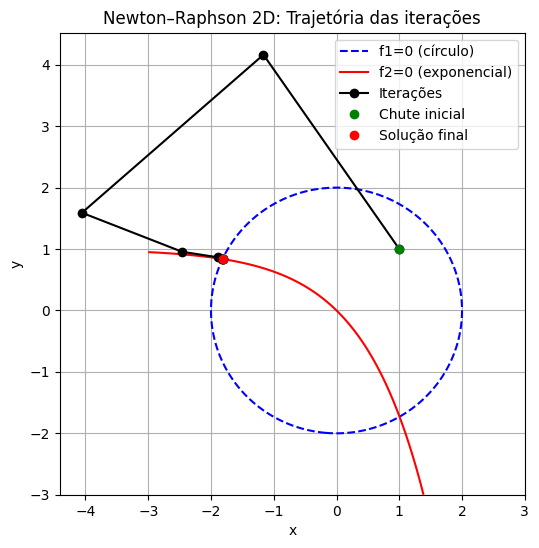

In [6]:
# Execução do exemplo em 2D
sol2d, hist2d = newton_raphson_2d(f1_2d, f2_2d, jacobian, 1.0, 1.0)
print(f"Solução 2D: x = {sol2d[0]:.6f}, y = {sol2d[1]:.6f}")

# Visualização da trajetória em 2D
try:
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    xs, ys = zip(*hist2d)
    Xg = np.linspace(-3,3,400)
    Yg = np.linspace(-3,3,400)
    X, Y = np.meshgrid(Xg, Yg)
    plt.figure(figsize=(6,6))
    cs1 = plt.contour(X, Y, f1_2d(X, Y), levels=[0], colors='blue', linestyles='--')
    cs2 = plt.contour(X, Y, f2_2d(X, Y), levels=[0], colors='red')
    plt.plot(xs, ys, 'o-', color='black', label='Iterações')
    plt.plot(xs[0], ys[0], 'go', label='Chute inicial')
    plt.plot(xs[-1], ys[-1], 'ro', label='Solução final')
    proxy1 = Line2D([0],[0], color='blue', linestyle='--')
    proxy2 = Line2D([0],[0], color='red', linestyle='-')
    proxy3 = Line2D([0],[0], marker='o', color='black', linestyle='-')
    proxy4 = Line2D([0],[0], marker='o', color = 'green', linestyle='')
    proxy5 = Line2D([0],[0], marker='o', color ='red', linestyle='')
    plt.legend([proxy1, proxy2, proxy3, proxy4, proxy5],
               ['f1=0 (círculo)', 'f2=0 (exponencial)', 'Iterações', 'Chute inicial', 'Solução final'])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Newton–Raphson 2D: Trajetória das iterações')
    plt.grid(True)
    plt.show()
except ImportError:
    print("Matplotlib não disponível. Trajetória:", hist2d)

## 4. Observações Finais

- Newton–Raphson lineariza localmente a função via derivada ou jacobiana.
- Convergência rápida quando bem inicializado.
- Muito usado em física para resolver equações transcendentais, orbitais, sistemas de equilíbrio etc.

---